First building the hybrid graph.

```r
library(future)
source("../graph_build/data_preprocess_utility_PCA.R")
source("../graph_build/filter_PCA.R")
plan(strategy = "multicore")
options(future.globals.maxSize = 100000 * 1024^14)

count <- readRDS("../../data/snare/count.list.rds")
label <- readRDS("../../data/snare/label.list.rds")

save_processed_data(count, label, dir = "../../data/snare/input", K_inter = 50, K_intra = 10,n_gene=5000, dim = 50)
fix_index("../../data/snare/input")
acc_intra_graph1("../../data/snare/input")
filter4_weight("../../data/snare/input")

In [2]:
import argparse
import sys
import os, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import subgraph
from torch_scatter import scatter
import dataset
from dataset import input_dataset
from utils import read_data, scGT_output
from parse import parse_method
from train import model_train
from plot import umap_emb
from scGT import *
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
parser = argparse.ArgumentParser()
default_args = {
    'dataset': 'data',
    'data_dir': '../data/snare0319/', 
    'device': 0, 
    'seed': 42, 
    'maxepochs': 5000,
    'eval_step': 10,
    'model_dir': '../model/', 
    'hidden_channels': 128,
    'lr': 5e-4,              
    'weight_decay': 1e-2,
    'lamda1': 0.1,          
    'lamda2': 0.1,          
    'num_batch': 1,          
    'early_stop':30,        
    'is_move': True         
}
"""
'data_dir': Input path
'model_dir': Model storage path
'seed': Seed
'lr': Learning rate
'lamda1': Hard regularity relaxation coefficient
'lamda2': Query graph regularity relaxation coefficient
'num_batch': How many subgraphs to create. If the GPU allows, it's best to be as small as possible
'early_stop': Early stop epoch
'is_move': Whether move query data to reference if confidence score > 0.95
"""


args = argparse.Namespace(**default_args)
print(args)

fix_seed(args.seed)
device = torch.device("cuda:" + str(args.device)) if torch.cuda.is_available() else torch.device("cpu")

Namespace(data_dir='../data/snare0319/', dataset='data', device=0, early_stop=30, eval_step=10, hidden_channels=128, is_move=True, lamda1=0.1, lamda2=0.1, lr=0.0005, maxepochs=5000, model_dir='../model/', num_batch=1, seed=42, weight_decay=0.01)


In [4]:
%%time
import time

### Load and preprocess data ###
dataset = input_dataset(args.data_dir, args.dataset)
dataset, x, n, c, d, split_idx, adjs, adj_loss_inter, adj_loss_intra2 = read_data(args, dataset)

num nodes 17630 | num edges 90232 | num classes 22 | num node feats 18738
CPU times: user 17.7 s, sys: 8.36 s, total: 26.1 s
Wall time: 18.2 s


In [5]:
### Load method ###
model = parse_method(args, dataset, n, c, d, device)
model.train()
print('MODEL:', model)

MODEL: scGT(
  (convs): ModuleList(
    (0-1): 2 x NodeFormerConv(
      (Wk): Linear(in_features=128, out_features=128, bias=True)
      (Wq): Linear(in_features=128, out_features=128, bias=True)
      (Wv): Linear(in_features=128, out_features=128, bias=True)
      (Wo): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (fcs): ModuleList(
    (0): Linear(in_features=18738, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=22, bias=True)
  )
  (bns): ModuleList(
    (0-2): 3 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
)


In [6]:
### Train ###
model_train(args, dataset, model, split_idx, device, x, n, adjs, adj_loss_inter, adj_loss_intra2)

Epoch: 00, Loss: 5.8286, Cross Entropy Loss: 3.2911, Hard regularity: 1.7033, Query Graph regularity: 0.8343, Reference: 40.22% 
Epoch: 10, Loss: 0.8574, Cross Entropy Loss: 0.5888, Hard regularity: 0.1142, Query Graph regularity: 0.1543, Reference: 97.24% 
Epoch: 20, Loss: 0.3281, Cross Entropy Loss: 0.1458, Hard regularity: 0.0904, Query Graph regularity: 0.0920, Reference: 99.57% 
Epoch: 30, Loss: 0.1668, Cross Entropy Loss: 0.0829, Hard regularity: 0.0081, Query Graph regularity: 0.0759, Reference: 99.86% 
Epoch: 40, Loss: 0.1170, Cross Entropy Loss: 0.0502, Hard regularity: 0.0000, Query Graph regularity: 0.0668, Reference: 99.98% 
Epoch: 50, Loss: 0.1044, Cross Entropy Loss: 0.0340, Hard regularity: 0.0000, Query Graph regularity: 0.0704, Reference: 99.98% 
Epoch: 60, Loss: 0.1071, Cross Entropy Loss: 0.0281, Hard regularity: 0.0000, Query Graph regularity: 0.0789, Reference: 99.99% 
Epoch: 70, Loss: 0.1079, Cross Entropy Loss: 0.0235, Hard regularity: 0.0000, Query Graph regular

In [7]:
### umap_emb ###
embedding_umap, label, pre, tech = umap_emb(args, model, dataset, x, adjs)

{0: 'Ast', 1: 'Clau', 2: 'E2Rasgrf2', 3: 'E3Rmst', 4: 'E3Rorb', 5: 'E4Il1rapl2', 6: 'E4Thsd7a', 7: 'E5Galnt14', 8: 'E5Parm1', 9: 'E5Sulf1', 10: 'E5Tshz2', 11: 'E6Tle4', 12: 'Endo', 13: 'InN', 14: 'InP', 15: 'InS', 16: 'InV', 17: 'Mic', 18: 'OPC', 19: 'OliI', 20: 'OliM', 21: 'Peri'}


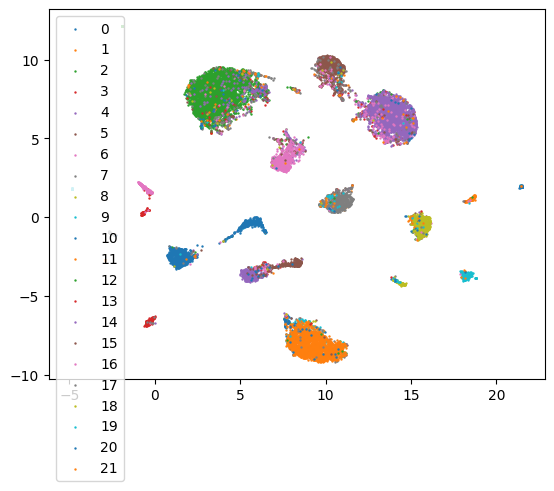

In [8]:
# celltype
%matplotlib inline
labels = np.unique(label)
for i in labels:
    plt.scatter(embedding_umap[label == i, 0], embedding_umap[label == i, 1], s=0.5, label=str(i))
plt.legend()
plt.show()

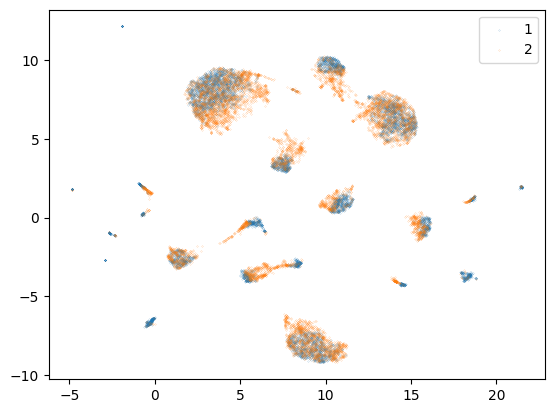

In [9]:
# tech
%matplotlib inline
techs = np.unique(tech) 
for i in techs:
    plt.scatter(embedding_umap[tech == i, 0], embedding_umap[tech == i, 1], s=0.01, label=str(i))
plt.legend()
plt.show()

In [12]:
# 'data_dir'+'results/embedding.pt'   is the low-dimensional embedding for joint visualization
output = scGT_output(args)
output[-20:-10] 

,celltype,prediction,omic,Confidence score
17610,E4Il1rapl2,E4Thsd7a,scATAC-seq,0.563411
17611,E2Rasgrf2,E2Rasgrf2,scATAC-seq,0.939053
17612,E3Rorb,E3Rorb,scATAC-seq,0.950790
17613,Ast,Ast,scATAC-seq,0.947180
17614,E2Rasgrf2,E2Rasgrf2,scATAC-seq,0.950863
17615,E5Sulf1,E6Tle4,scATAC-seq,0.913112
17616,E6Tle4,E6Tle4,scATAC-seq,0.799009
17617,E2Rasgrf2,E2Rasgrf2,scATAC-seq,0.963834
17618,E3Rorb,E3Rorb,scATAC-seq,0.913163
17619,E6Tle4,E6Tle4,scATAC-seq,0.910459
